# Precision and recall

In the classification problem, one may encounter problem in the case of _skewed classes_.
For such cases, even naive hypothesis like $h_\theta(x) = 1$ may have smaller cost then trained classifiers.
To measure the quality of classifiers one could use a few additional metrics, namely, _precision_ and _recall_.
Below there are defiened a few quantities and metric which can be used for handling _skew classes_ problem.


| predicted class $\downarrow$ / actual class $\rightarrow$ | 1              | 0              |
|-----------------------------------------------------------|----------------|----------------|
| **1**                                                     | true positive  | false positive |
| **0**                                                     | false negative | true negative  |  


$$ P = \text{precision} = \frac{\#\text{true positive}}{\#\text{true positive} + \#\text{false positive}}$$

$$ R = \text{recall} = \frac{\#\text{true positive}}{\#\text{true positive} + \#\text{false negative}}$$

$$F_1\text{ score} = \frac{2PR}{P+R}$$

## $F_1$ score

In [1]:
import numpy as np
import matplotlib.pyplot as plt

h = lambda theta, x: 1. / (1. + np.exp(-theta.T @ x))

def gradient_descent(theta, x, y, k=1000, alpha=0.1, lam=0):
    delta = np.ones(theta.shape)
    delta[0] = 0
    gradJ = lambda theta, x, y: .5 / x.shape[1] * (((h(theta, x) - y) * x).sum(axis=1).reshape(theta.shape) + lam * theta * delta)
    for _ in range(k):
        theta = theta - alpha * gradJ(theta, x, y)
    return theta

def create_polynomial_features(x, degree=1):
    return np.hstack(tuple([x ** i for i in range(degree + 1)])).T

def cost(h, theta, x, y):
    hx = h(theta, x)
    h0 = (hx < 1) & (hx > 0)
    c0 = lambda id: -1. / x.shape[1] * (y[id] * np.log(hx[id])).sum()
    c1 = lambda id: -1. / x.shape[1] * ((1 - y[id]) * np.log(1 - hx[id])).sum()
    return c0(h0) + c1(h0)

def precision(h, theta, x, y):
    true_positive = ((h(theta, x) >= 0.5) & (y == 1)).sum()
    false_positive = ((h(theta, x) >= 0.5) & (y == 0)).sum()
    return true_positive / (true_positive + false_positive)

def recall(h, theta, x, y):
    true_positive = ((h(theta, x) >= 0.5) & (y == 1)).sum()
    false_negative = ((h(theta, x) < 0.5) & (y == 1)).sum()
    return true_positive / (true_positive + false_negative)

def f1_score(h, theta, x, y):
    p = precision(h, theta, x, y)
    r = recall(h, theta, x, y)
    return 2 * p * r / (p + r)

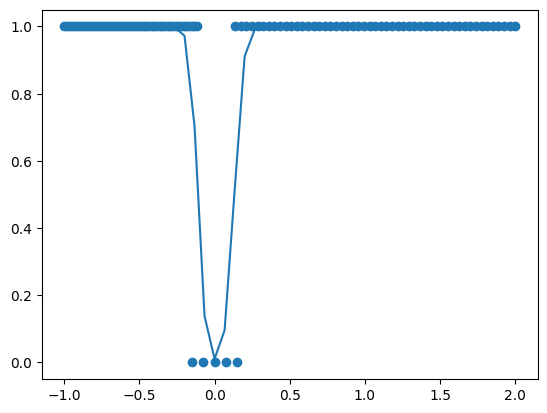

In [2]:
x0 = np.linspace(-0.15, 0.15, 5).reshape(-1, 1)
x1 = np.vstack((
    +np.linspace(-1, -0.1, 51, endpoint=False).reshape(-1, 1),
    -np.linspace(-2, -0.1, 51, endpoint=False).reshape(-1, 1)
    ))
x = np.vstack((x0, x1))
y0 = np.zeros(x0.shape)
y1 = np.ones(x1.shape)
y = np.vstack((y0, y1))

X = np.hstack((np.ones(x.shape), x, np.abs(x)))
theta = gradient_descent(np.random.rand(3, 1), x=X.T, y=y.T, k=100_000, alpha=1)

fig, ax = plt.subplots()
ax.scatter(x, y)
linx = np.linspace(-1, 1, 31).reshape(-1, 1)
linX = np.hstack((np.ones(linx.shape), linx, np.abs(linx))).T
liny = 1./(1 + np.exp(-theta.T @ linX)).T
ax.plot(linx, liny)
plt.show()

In [3]:
naive_h = lambda theta, x: np.ones((1, x.shape[1]))

print(f"""
    ================================
    logistic regression: 
    h(x) = theta_0 + theta_1 * x + theta_2 * |x|
    ================================
    cost:     {cost(h, theta, X.T, y.T)}
    precision:{precision(h, theta, X.T, y.T)} 
    recall:   {recall(h, theta, X.T, y.T)}
    f1 score: {f1_score(h, theta, X.T, y.T)}
    """)

print(f"""
    ================================
    naive hypothesis:
    h(x) = 1
    ================================
    cost:     {cost(naive_h, theta, X.T, y.T)}
    precision:{precision(naive_h, theta, X.T, y.T)} 
    recall:   {recall(naive_h, theta, X.T, y.T)}
    f1 score: {f1_score(naive_h, theta, X.T, y.T)}
    """)

print(f"Naive hypothesis has smaller cost than logistic regression? {cost(h, theta, X.T, y.T) > cost(naive_h, theta, X.T, y.T)}")
print(f"Logistic regression has better score than naive hypothesis? {f1_score(h, theta, X.T, y.T) > f1_score(naive_h, theta, X.T, y.T)}")


    logistic regression: 
    h(x) = theta_0 + theta_1 * x + theta_2 * |x|
    cost:     0.04950290939296981
    precision:0.9807692307692307 
    recall:   1.0
    f1 score: 0.9902912621359222
    

    naive hypothesis:
    h(x) = 1
    cost:     -0.0
    precision:0.9532710280373832 
    recall:   1.0
    f1 score: 0.9760765550239235
    
Naive hypothesis has smaller cost than logistic regression? True
Logistic regression has better score than naive hypothesis? True


## Threshold manipulation

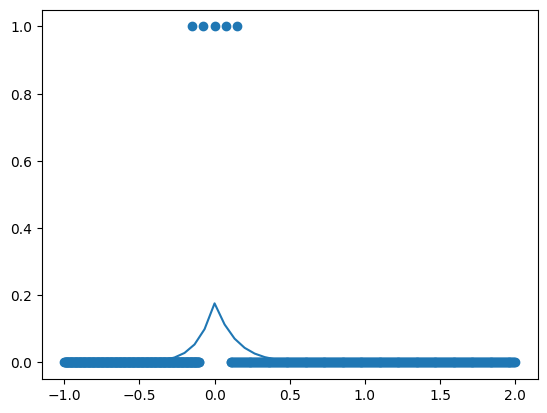

In [4]:
x0 = np.vstack((
    +np.linspace(-1, -0.1, 301, endpoint=False).reshape(-1, 1),
    -np.linspace(-2, -0.1, 301, endpoint=False).reshape(-1, 1)
    ))
x1 = np.linspace(-0.15, 0.15, 5).reshape(-1, 1)
x = np.vstack((x0, x1))
y0 = np.zeros(x0.shape)
y1 = np.ones(x1.shape)
y = np.vstack((y0, y1))

X = np.hstack((np.ones(x.shape), x, np.abs(x)))
theta = gradient_descent(np.random.rand(3, 1), x=X.T, y=y.T, k=10_000, alpha=1)

fig, ax = plt.subplots()
ax.scatter(x, y)
linx = np.linspace(-1, 1, 31).reshape(-1, 1)
linX = np.hstack((np.ones(linx.shape), linx, np.abs(linx))).T
liny = 1./(1 + np.exp(-theta.T @ linX)).T
ax.plot(linx, liny)
plt.show()

/tmp/ipykernel_470/4039647350.py:27: RuntimeWarning: invalid value encountered in scalar divide
  return true_positive / (true_positive + false_positive)


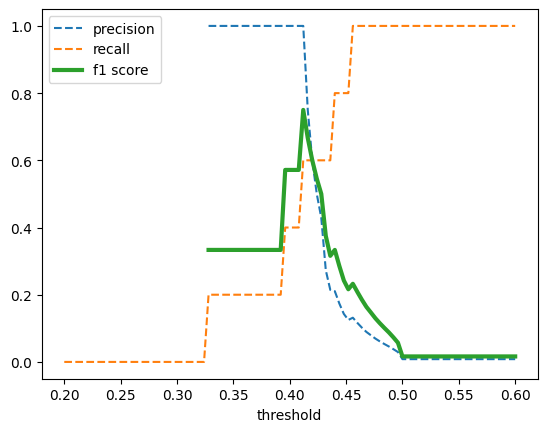

In [6]:
threshold = np.linspace(0.2, 0.6, 101)
p = np.zeros(threshold.shape)
r = np.zeros(threshold.shape)
f1 = np.zeros(threshold.shape)
for i in range(threshold.size):
    p[i] = precision(lambda theta, x: h(theta, x) + threshold[i], theta, X.T, y.T)
    r[i] = recall(lambda theta, x: h(theta, x) + threshold[i], theta, X.T, y.T)
    f1[i] = f1_score(lambda theta, x: h(theta, x) + threshold[i], theta, X.T, y.T)

fig, ax = plt.subplots()
ax.plot(threshold, p, '--', label="precision")
ax.plot(threshold, r, '--', label="recall")
ax.plot(threshold, f1, linewidth=3, label="f1 score")
ax.set_xlabel("threshold")
ax.legend()
plt.show()

## Conclusions

In the following notebook, we investigate classification problems with _skewed classes_. Using the cost $J(\theta)$ as a quality metric is not a good solution for _skewed classes_, however, using $F_1$ score can provide a good measurement of the hypothesis. Additionally, we show that adding a threshold to logistic regression can provide a better score.